## Audio diffusion using latent DDIM diffusion

This works by taking samples from the latent space of the model using a different seed. 

We can then interpolate between samples, however randomly sampling from latent space makes it difficult to find audio that sounds good. 

Perhapse experiment with clustering or finding clusters? 

Also chaging the seed could be an interesting control

In [1]:
import torch
from IPython.display import Audio
import random
import numpy as np
from diffusers import DiffusionPipeline, DDIMScheduler, AutoencoderKL
from diffusers_local import UNet2DModel as UNet2DModel_local

device = "cuda" if torch.cuda.is_available() else "cpu"
audio_diffusion = DiffusionPipeline.from_pretrained("teticio/latent-audio-diffusion-256")
# apply the custom unet model so we can Networkbend the audio
audio_diffusion.unet = UNet2DModel_local.from_pretrained("teticio/latent-audio-diffusion-256", subfolder="unet")
#set the scheduler to DDIM
audio_diffusion.scheduler = DDIMScheduler.from_pretrained("teticio/latent-audio-diffusion-256", subfolder="scheduler")
#set the vqvae
audio_diffusion.vqvae = AutoencoderKL.from_pretrained("teticio/latent-audio-diffusion-256", subfolder="vqvae")
#load the model to the GPU/CPU
audio_diffusion.to(device)

#print(audio_diffusion)

#define the vae so we can access the latent space
vae = audio_diffusion.vqvae
#fix the generator seed for deterministic results
#generator=torch.Generator(device="cpu").manual_seed(42)

c:\Users\danhearn\.conda\envs\diffusertrack\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\danhearn\.conda\envs\diffusertrack\Lib\site-packages\kornia\feature\lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
vqvae\diffusion_pytorch_model.safetensors not found
Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]An error occurred while trying to fetch C:\Users\danhearn\.cache\huggingface\hub\models--teticio--latent-audio-diffusion-256\snapshots\0937986e5962b194394bb29206cb12fa2f0bc655\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\danhearn\.cache\huggingface\hub\models--teticio--latent-a

In [2]:
#encode images in latent space
encoded_images = []

for i in range(10):
    generator = torch.Generator(device="cuda").manual_seed(random.randint(0, 1000))
    encoded_images.append(
        torch.randn(
            (1, audio_diffusion.unet.in_channels, audio_diffusion.unet.sample_size[0], audio_diffusion.unet.sample_size[1]),
            generator=generator,
            device="cuda")
    )


C:\Users\danhearn\AppData\Local\Temp\ipykernel_13880\3265152230.py:8: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, audio_diffusion.unet.in_channels, audio_diffusion.unet.sample_size[0], audio_diffusion.unet.sample_size[1]),


  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\danhearn\Documents\GitHub\diffusertrack\diffusers_local\models\attention_processor.py:2367: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(
100%|██████████| 10/10 [00:00<00:00, 18.51it/s]


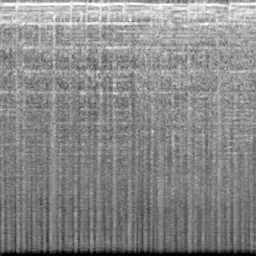

In [3]:
alpha = 0.5  #@param {type:"slider", min:0, max:1, step:0.1}
output = audio_diffusion(steps=10,
    noise=audio_diffusion.slerp(encoded_images[1], encoded_images[4], alpha),
    generator=generator)
display(output.images[0])
display(Audio(output.audios[0], rate=audio_diffusion.mel.get_sample_rate()))